# CNN Model on NSL-KDD

This notebook trains and evaluates a 1D Convolutional Neural Network (CNN) on the preprocessed NSL-KDD dataset.

## 1. Imports and setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
)

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

sns.set(style="whitegrid")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

## 2. Load preprocessed train / test data

In [2]:
X_train = np.load("../data/processed/X_train.npy").astype("float32")
X_test  = np.load("../data/processed/X_test.npy").astype("float32")
y_train = np.load("../data/processed/y_train.npy").astype("int32").ravel()
y_test  = np.load("../data/processed/y_test.npy").astype("int32").ravel()

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test  shape:", y_test.shape)

n_features = X_train.shape[1]
print("Number of features:", n_features)

X_train shape: (125973, 41)
X_test  shape: (22544, 41)
y_train shape: (125973,)
y_test  shape: (22544,)
Number of features: 41


## 3. Reshape data for 1D CNN

In [3]:
X_train_cnn = np.expand_dims(X_train, axis=-1)
X_test_cnn  = np.expand_dims(X_test, axis=-1)

print("X_train_cnn shape:", X_train_cnn.shape)
print("X_test_cnn  shape:", X_test_cnn.shape)

X_train_cnn shape: (125973, 41, 1)
X_test_cnn  shape: (22544, 41, 1)


## 4. Build 1D CNN model

In [4]:
input_shape = (n_features, 1)

model_cnn = models.Sequential([
    layers.Input(shape=input_shape),

    # Block 1
    layers.Conv1D(128, kernel_size=3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv1D(128, kernel_size=3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),

    # Block 2
    layers.Conv1D(256, kernel_size=3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv1D(256, kernel_size=3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),

    layers.GlobalAveragePooling1D(),

    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(1, activation="sigmoid"),  # binary output: normal vs attack
])

model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
    ],
)

model_cnn.summary()

2025-11-27 11:45:26.015141: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-11-27 11:45:26.015291: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-27 11:45:26.015298: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-11-27 11:45:26.015579: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-27 11:45:26.015592: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 41, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 41, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 41, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 41, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 20, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 20, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 447,105 (1.71 MB)

 Trainable params: 445,569 (1.70 MB)

 Non-trainable params: 1,536 (6.00 KB)

## 5. Train the CNN

In [5]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights: make errors on attacks (class 1) more costly
classes = np.array([0, 1])
class_weights_arr = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train,
)
class_weight_dict = {0: float(class_weights_arr[0]), 1: float(class_weights_arr[1])}
print("Class weights:", class_weight_dict)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True,
    verbose=1,
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1,
)

history_cnn = model_cnn.fit(
    X_train_cnn,
    y_train,
    epochs=80,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1,
)

Class weights: {0: 0.9353087923020953, 1: 1.0743049633293535}
Epoch 1/80


2025-11-27 11:45:26.769531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


394/394 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.9533 - auc: 0.9733 - loss: 0.6510 - val_accuracy: 0.5338 - val_auc: 0.5000 - val_loss: 205.3594 - learning_rate: 0.0010
Epoch 2/80
394/394 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.9321 - auc: 0.9402 - loss: 2.7756 - val_accuracy: 0.9715 - val_auc: 0.9734 - val_loss: 1.0950 - learning_rate: 0.0010
Epoch 3/80
394/394 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.9301 - auc: 0.9335 - loss: 10.9967 - val_accuracy: 0.9372 - val_auc: 0.9378 - val_loss: 19.4906 - learning_rate: 0.0010
Epoch 4/80
394/394 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.9266 - auc: 0.9276 - loss: 48.8256 - val_accuracy: 0.9576 - val_auc: 0.9554 - val_loss: 68.0533 - learning_rate: 0.0010
Epoch 5/80
393/394 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9179 - auc: 0.9190 - loss: 143.9289
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
394/394 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.9199 - auc: 0.9206 - loss

## 6. Training curves (accuracy & loss)

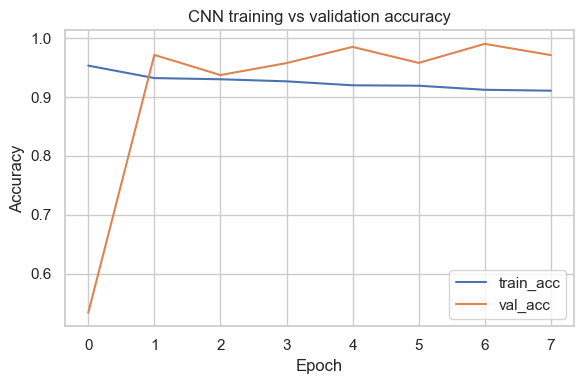

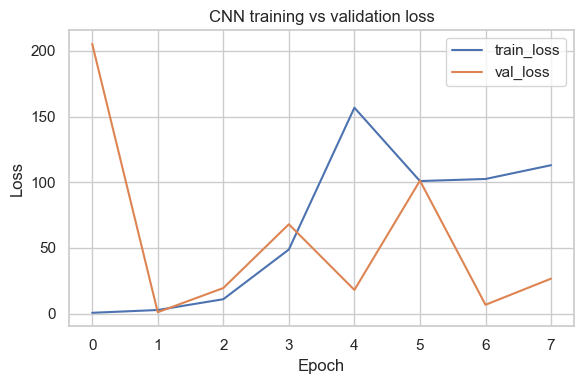

In [6]:
# Accuracy
plt.figure(figsize=(6, 4))
plt.plot(history_cnn.history["accuracy"], label="train_acc")
plt.plot(history_cnn.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN training vs validation accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Loss
plt.figure(figsize=(6, 4))
plt.plot(history_cnn.history["loss"], label="train_loss")
plt.plot(history_cnn.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN training vs validation loss")
plt.legend()
plt.tight_layout()
plt.show()

## 7. Evaluation on test set

In [7]:
# Base evaluation (for reference)
test_loss_cnn, test_acc_cnn, test_auc_cnn = model_cnn.evaluate(
    X_test_cnn, y_test, verbose=0
)
print(f"Test loss (default) : {test_loss_cnn:.4f}")
print(f"Test acc  (default) : {test_acc_cnn:.4f}")
print(f"Test AUC  (default) : {test_auc_cnn:.4f}")

# Probabilities for class 1 (attack)
y_prob_cnn = model_cnn.predict(X_test_cnn, batch_size=512).ravel()

# Search for best threshold by F1 (attack class = 1)
thresholds = np.linspace(0.1, 0.9, 33)

best_t = 0.5
best_f1 = -1.0
best_prec = 0.0
best_rec = 0.0

for t in thresholds:
    y_pred_t = (y_prob_cnn >= t).astype("int32")
    f1_t = f1_score(y_test, y_pred_t)
    prec_t = precision_score(y_test, y_pred_t)
    rec_t = recall_score(y_test, y_pred_t)
    if f1_t > best_f1:
        best_f1 = f1_t
        best_t = t
        best_prec = prec_t
        best_rec = rec_t

print("\n=== Best threshold search (by F1) ===")
print(f"Best threshold: {best_t:.3f}")
print(f"Precision@best_t: {best_prec:.4f}")
print(f"Recall@best_t   : {best_rec:.4f}")
print(f"F1@best_t       : {best_f1:.4f}")

# Final predictions using best threshold
y_pred_cnn = (y_prob_cnn >= best_t).astype("int32")

acc_cnn  = accuracy_score(y_test, y_pred_cnn)
prec_cnn = precision_score(y_test, y_pred_cnn)
rec_cnn  = recall_score(y_test, y_pred_cnn)
f1_cnn   = f1_score(y_test, y_pred_cnn)
auc_cnn  = roc_auc_score(y_test, y_prob_cnn)

print("\n=== CNN metrics on test set (tuned threshold) ===")
print(f"Threshold: {best_t:.3f}")
print(f"Accuracy : {acc_cnn:.4f}")
print(f"Precision: {prec_cnn:.4f}")
print(f"Recall   : {rec_cnn:.4f}")
print(f"F1-score : {f1_cnn:.4f}")
print(f"ROC-AUC  : {auc_cnn:.4f}")

print("\nClassification report (0 = normal, 1 = attack):\n")
print(classification_report(y_test, y_pred_cnn, target_names=["normal", "attack"]))

Test loss (default) : 15.3586
Test acc  (default) : 0.7531
Test AUC  (default) : 0.7834
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

=== Best threshold search (by F1) ===
Best threshold: 0.100
Precision@best_t: 0.9324
Recall@best_t   : 0.6173
F1@best_t       : 0.7428

=== CNN metrics on test set (tuned threshold) ===
Threshold: 0.100
Accuracy : 0.7567
Precision: 0.9324
Recall   : 0.6173
F1-score : 0.7428
ROC-AUC  : 0.8787

Classification report (0 = normal, 1 = attack):

              precision    recall  f1-score   support

      normal       0.65      0.94      0.77      9711
      attack       0.93      0.62      0.74     12833

    accuracy                           0.76     22544
   macro avg       0.79      0.78      0.76     22544
weighted avg       0.81      0.76      0.75     22544



## 8. Confusion matrix & ROC curve

Confusion matrix (CNN, tuned threshold):
[[9137  574]
 [4911 7922]]


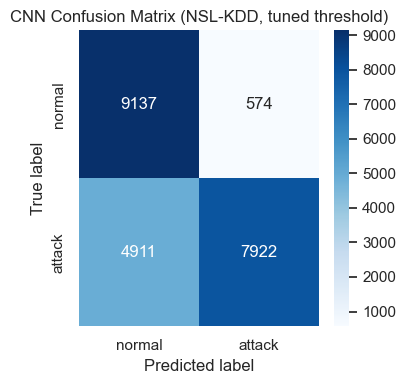

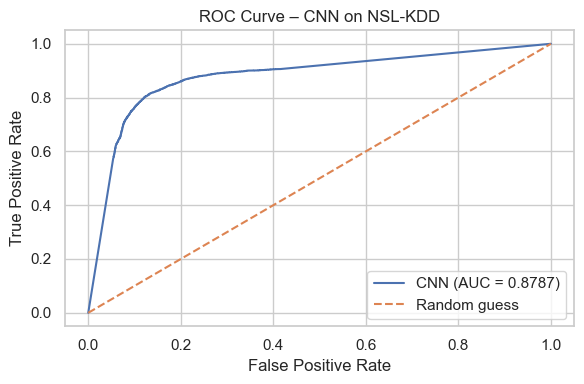

In [8]:
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
print("Confusion matrix (CNN, tuned threshold):")
print(cm_cnn)

plt.figure(figsize=(4, 4))
sns.heatmap(
    cm_cnn,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["normal", "attack"],
    yticklabels=["normal", "attack"],
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("CNN Confusion Matrix (NSL-KDD, tuned threshold)")
plt.tight_layout()
plt.show()

fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_prob_cnn)
roc_auc_plot_cnn = auc(fpr_cnn, tpr_cnn)

plt.figure(figsize=(6, 4))
plt.plot(fpr_cnn, tpr_cnn, label=f"CNN (AUC = {roc_auc_plot_cnn:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – CNN on NSL-KDD")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## 9. Summary table

In [9]:
metrics_cnn = pd.DataFrame(
    {
        "model": ["CNN"],
        "accuracy": [acc_cnn],
        "precision": [prec_cnn],
        "recall": [rec_cnn],
        "f1": [f1_cnn],
        "roc_auc": [auc_cnn],
    }
)

metrics_cnn

import os

os.makedirs("../results", exist_ok=True)
cnn_metrics_path = "../results/cnn_metrics.csv"
metrics_cnn.to_csv(cnn_metrics_path, index=False)
print(f"Saved CNN metrics to {cnn_metrics_path}")



Saved CNN metrics to ../results/cnn_metrics.csv


# 10. Adversarial Attacks: FGSM and PGD

In [10]:
import tensorflow as tf

bce_loss = tf.keras.losses.BinaryCrossentropy()

def fgsm_attack(model, x, y, epsilon=0.05):
    """
    One-step FGSM attack (L_inf).
    x: numpy or tf tensor of shape (N, 41, 1)
    y: numpy array of 0/1 labels
    """
    x_tf = tf.convert_to_tensor(x, dtype=tf.float32)
    y_tf = tf.convert_to_tensor(y, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(x_tf)
        y_pred = model(x_tf, training=False)
        loss = bce_loss(y_tf, y_pred)

    grad = tape.gradient(loss, x_tf)
    signed_grad = tf.sign(grad)

    x_adv = x_tf + epsilon * signed_grad
    x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)

    return x_adv.numpy()


def pgd_attack(model, x, y, epsilon=0.05, alpha=0.01, num_iter=20):
    """
    Iterative PGD attack (L_inf) with projection.
    epsilon: max total perturbation
    alpha: step size per iteration
    num_iter: number of gradient steps
    """
    x_orig = tf.convert_to_tensor(x, dtype=tf.float32)
    y_tf = tf.convert_to_tensor(y, dtype=tf.float32)

    # start from original inputs
    x_adv = tf.identity(x_orig)

    for i in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            y_pred = model(x_adv, training=False)
            loss = bce_loss(y_tf, y_pred)

        grad = tape.gradient(loss, x_adv)
        signed_grad = tf.sign(grad)

        # small step in gradient direction
        x_adv = x_adv + alpha * signed_grad

        # project back into epsilon-ball around original inputs
        eta = tf.clip_by_value(x_adv - x_orig, -epsilon, epsilon)
        x_adv = x_orig + eta

        # keep features in [0,1]
        x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)

    return x_adv.numpy()

    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_under_attack(X_adv, name, threshold, y_true):
    """
    Helper: compute metrics using the SAME threshold as clean model.
    """
    # model outputs probabilities for class 1 (attack)
    y_prob = model_cnn.predict(X_adv, batch_size=512).ravel()
    y_pred = (y_prob >= threshold).astype("int32")

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)
    auc  = roc_auc_score(y_true, y_prob)

    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC AUC  : {auc:.4f}")

    return {
        "model": [name],
        "accuracy": [acc],
        "precision": [prec],
        "recall": [rec],
        "f1": [f1],
        "roc_auc": [auc],
    }


# 10.1 FGSM attack
epsilon_fgsm = 0.05   # you can try 0.01, 0.05, 0.1 etc.

X_test_fgsm = fgsm_attack(model_cnn, X_test_cnn, y_test, epsilon=epsilon_fgsm)
metrics_fgsm = evaluate_under_attack(
    X_test_fgsm,
    name=f"FGSM (eps={epsilon_fgsm})",
    threshold=best_t,
    y_true=y_test,
)

# 10.2 PGD attack
epsilon_pgd = 0.05
alpha_pgd   = 0.01
iters_pgd   = 20

X_test_pgd = pgd_attack(
    model_cnn,
    X_test_cnn,
    y_test,
    epsilon=epsilon_pgd,
    alpha=alpha_pgd,
    num_iter=iters_pgd,
)
metrics_pgd = evaluate_under_attack(
    X_test_pgd,
    name=f"PGD (eps={epsilon_pgd}, alpha={alpha_pgd}, iters={iters_pgd})",
    threshold=best_t,
    y_true=y_test,
)

metrics_clean = {
    "model": ["CNN (clean)"],
    "accuracy": [acc_cnn],
    "precision": [prec_cnn],
    "recall": [rec_cnn],
    "f1": [f1_cnn],
    "roc_auc": [auc_cnn],
}

metrics_all = pd.concat(
    [
        pd.DataFrame(metrics_clean),
        pd.DataFrame(metrics_fgsm),
        pd.DataFrame(metrics_pgd),
    ],
    ignore_index=True,
)

adv_metrics_path = "../results/cnn_adv_metrics.csv"
metrics_all.to_csv(adv_metrics_path, index=False)
print(f"Saved adversarial metrics to {adv_metrics_path}")
metrics_all


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

=== FGSM (eps=0.05) ===
Accuracy : 0.7009
Precision: 0.9262
Recall   : 0.5157
F1-score : 0.6625
ROC AUC  : 0.7252
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

=== PGD (eps=0.05, alpha=0.01, iters=20) ===
Accuracy : 0.6032
Precision: 0.7100
Recall   : 0.5120
F1-score : 0.5950
ROC AUC  : 0.5964
Saved adversarial metrics to ../results/cnn_adv_metrics.csv


,model,accuracy,precision,recall,f1,roc_auc
0,CNN (clean),0.756698,0.932439,0.617315,0.742838,0.878653
1,FGSM (eps=0.05),0.700940,0.926242,0.515702,0.662529,0.725228
2,"PGD (eps=0.05, alpha=0.01, iters=20)",0.603176,0.709995,0.512039,0.594984,0.596382
